In [428]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle


import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [429]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100

# True Posteriors

## Observing 2 random variable $ z_1, z_2 \sim \mathcal{N}(\theta, 1) $

In [430]:

#Say we observe z1, z2
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [431]:

def posterior_z(theta, z1=z1, z2=z2):
    """Posterior if we observe z1, z2"""
    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta-z1) + np.square(theta-z2))/2
        prior_part = np.square(theta)/50
        res = np.exp(likelihood_part)*np.exp(prior_part)
        return res
    Z_z1_z2, eps = integrate.quad(improper_posterior_z,-15,15) #Integrale of p_impropre(θ|z1,z2)
    return improper_posterior_z(theta, z1, z2)/Z_z1_z2


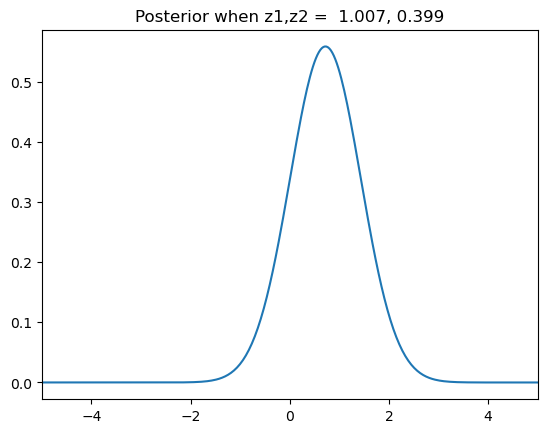

In [432]:
theta_grid = np.linspace(-15,15,1000)
eval_post = [posterior_z(theta, z1, z2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when z1,z2 =  {z1:.3f}, {z2:.3f}")
plt.show()

In [433]:
mu = (z1 +z2) /(2+1/25)
var = (2+1/25)**(-1)
mu

0.6891542643892998

In [434]:
def uniform_proposal(x, delta=2.0):
    return np.random.normal(x)#(x - delta, x + delta)

def metropolis_sampler(p, nsamples, proposal=uniform_proposal):
    x = 1 # start somewhere

    for i in tqdm(range(nsamples)):
        trial = proposal(x) # random neighbour from the proposal distribution
        acceptance = p(trial)/p(x)

        # accept the move conditionally
        if np.random.uniform() < acceptance:
            x = trial

        yield x
true_samples = list(metropolis_sampler(posterior_z, 10_000))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [435]:
print(f" mean samples = {np.mean(true_samples)} whereas theroretical mean = {mu}")
print(f" var samples = {np.var(true_samples)} whereas theroretical var = {var}")

 mean samples = 0.6818969592962171 whereas theroretical mean = 0.6891542643892998
 var samples = 0.500026632160876 whereas theroretical var = 0.49019607843137253


## Say we observed the mean of two random variables, $x= \frac{1}{2}(z_1 + z_2) $

In [436]:
x = (z1 + z2)/2

In [437]:
def posterior_x(theta, x=x):
    """Posterior when observing x=mean(z1, z2)"""
    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return improper_posterior_x(theta,x)/z_x

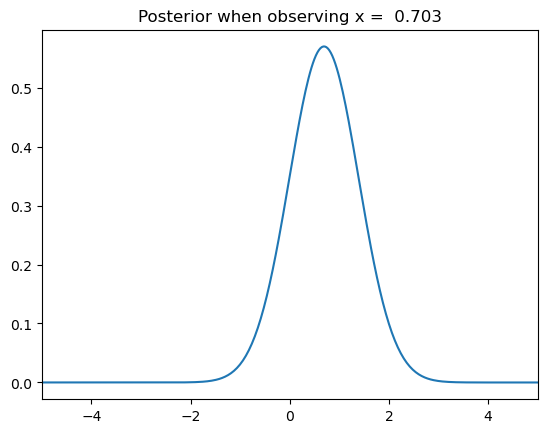

In [438]:
eval_post_x = [posterior_x(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.show()

## Say we observed the mean of N random variables

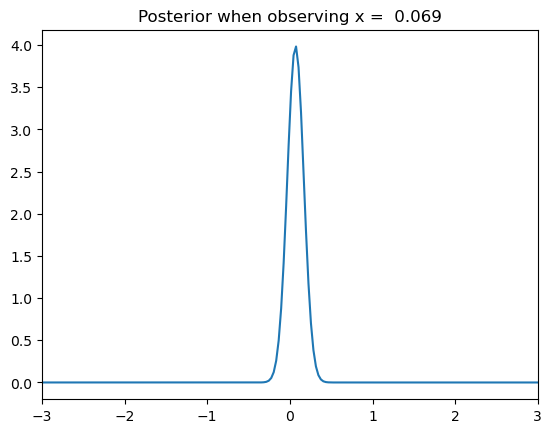

In [440]:
x = np.mean(zi)


def posterior_x_N(theta, x=x):
    """Posterior when observing x= mean(z1, z2... ,zn)"""
    def impropoer_posterior_x_N(theta, x=x):
        likelihood_part = -N*np.square(theta -x)/2
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x_n, eps = integrate.quad(impropoer_posterior_x_N,-15, 15)
    return impropoer_posterior_x_N(theta,x)/z_x_n



eval_post_x_n = [posterior_x_N(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x_n)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the mean and the variance of N random variables

In [442]:
x1 = np.mean(zi)
x2 = np.var(zi)
np.abs(x1 - theta_true)

tensor([0.0689])

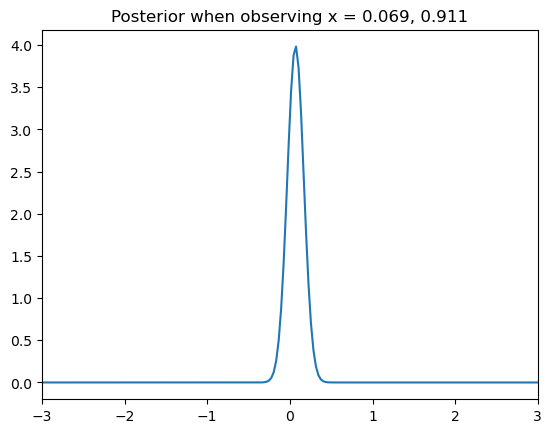

In [443]:
def posterior_summaries(theta, x1=x1, x2=x2):
    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""
    def impropoer_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/2
        likelihood_x2_part = -N*np.square(1 - x2)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)+1e-9
    z_summaries, eps = integrate.quad(impropoer_posterior_summaries, -25, 25)
    return impropoer_posterior_summaries(theta,x1,x2)/z_summaries

eval_post_summaries = [posterior_summaries(theta, x1, x2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_summaries)
plt.title(f"Posterior when observing x = {x1:.3f}, {x2:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the variance of N random variables

In [445]:
x=np.var(zi)

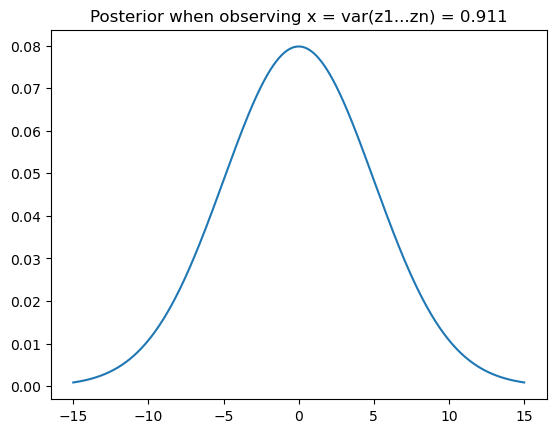

In [446]:
def posterior_var(theta, x=x):
    """Posterior when observing x= var(z1...zn)"""
    def improper_posterior_var(theta,x=x):
        likelihood_part = -N*np.square(x-1)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_var, -25, 25)
    return improper_posterior_var(theta,x)/z_summaries

eval_post_var= [posterior_var(theta, x2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_var)
plt.title(f"Posterior when observing x = var(z1...zn) = {x2:.3f}")
#plt.xlim(left=-3,right=3)
plt.show()

## Comparaison

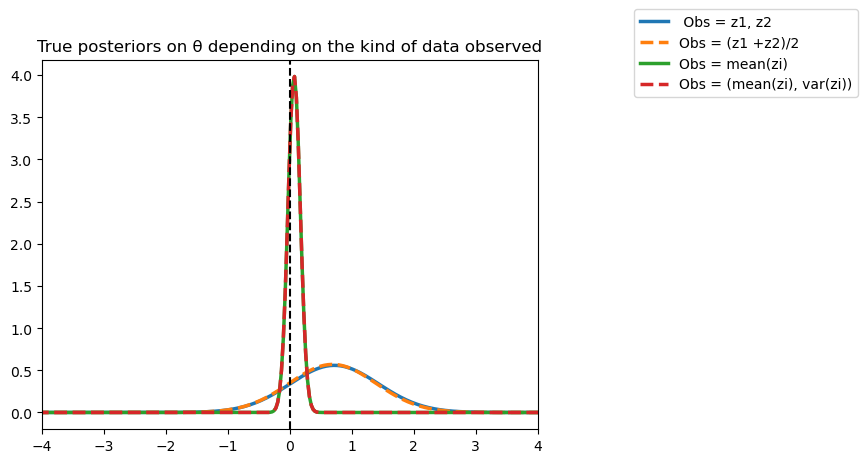

In [448]:
fig = plt.figure()
plt.xlim(left=-4, right=4)
plt.plot(theta_grid, eval_post, label=" Obs = z1, z2", linewidth=2.5)
plt.plot(theta_grid, eval_post_x, label="Obs = (z1 +z2)/2", linestyle='dashed', linewidth=2.5)
plt.plot(theta_grid, eval_post_x_n, label="Obs = mean(zi)", linewidth=2.5)
plt.plot(theta_grid, eval_post_summaries, label="Obs = (mean(zi), var(zi))", linestyle="dashed", linewidth=2.5)
#plt.plot(theta_grid, eval_post_var, label="Obs = var(zi)", linewidth=2.5)
plt.axvline(x=theta_true, ls='--', c='k')
fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("True posteriors on θ depending on the kind of data observed")
plt.show()


As expected the last 2 methods yield similar results

In [473]:
def get_true_post(summaries, x_star):
    if "two_z" == summaries:
        #We observe z1, z2
        post = [posterior_z(theta_i, x_star[0], x_star[1]) for theta_i in theta_grid]
        dist = posterior_z
    elif "mean_two_z"== summaries:
        #We observed x = mean(z1, z2)
        post = [posterior_x(theta_i,x_star) for theta_i in theta_grid]
        dist = posterior_x
    elif "var"==summaries:
        #We observe x=var(z1...zn)
        post = [posterior_var(theta_i, x_star) for theta_i in theta_grid]
        dist = posterior_var
    elif "var" in summaries and "mean" in summaries:
        #We observe x = (x1, x2) = (mean, var)
        post = [posterior_summaries(theta_i, x_star[0], x_star[1]) for theta_i in theta_grid]
        dist = posterior_summaries

    elif "mean"==summaries:
        #We observe x = mean(z1, ... z100)
        post = [posterior_x_N(theta_i, x_star) for theta_i in theta_grid]
        dist = posterior_x_N
    return post, dist

# Now let us compare these true posteriors to the estimations using SBI

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 17 epochs.

C:\Users\mmmat\AppData\Local\Temp\ipykernel_23500\2621513431.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


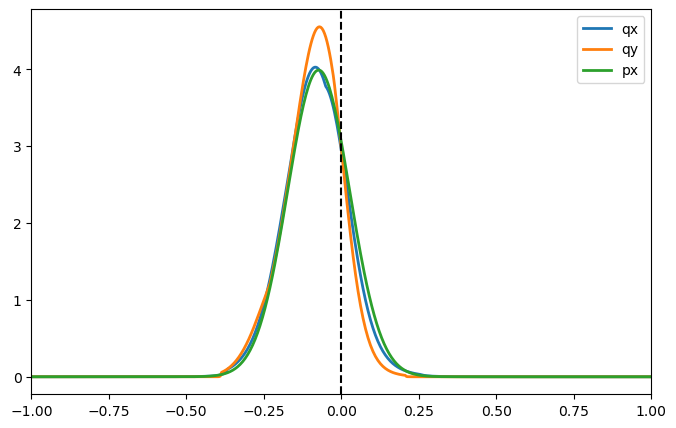

In [451]:


torch.manual_seed(42)

# define the prior over theta
prior = torch.distributions.Normal(
    loc=torch.tensor([0.0]), scale=torch.tensor([5.0])
)

# define the model to work with
def gaussian(theta, sigma, summ_stats):
    zx = torch.distributions.Normal(loc=theta, scale=sigma).sample((100,))
    sx = {}
    sx['mean'] = zx.mean()
    sx['var'] = zx.var()
    sx['raw'] = zx[0]
    sx['mean_two_realisations'] = torch.distributions.Normal(loc=theta, scale=sigma).sample((2,)).mean()
    ss = []
    for st in summ_stats:
        ss.append(sx[st])
    
    return torch.tensor(ss)

# choose which summary statistics to consider
ss = ['mean', 'var']

# fix the standard deviations of the zx
sigma_x = 1.0

# make sure that prior and model are in SBI format
simulator, prior = prepare_for_sbi(
    partial(gaussian, sigma=sigma_x, summ_stats=ss),
    prior)

# instantiate the density estimator to use
density_estimator_build_fun = posterior_nn(
    model="nsf",
    hidden_features=40,
    num_transforms=5,
    num_bins=10,
    num_blocks=2
)

# instantiate an inference object
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)

# generate the training dataset with simulations
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=50_000)
# store the simulations in the inference object
inference = inference.append_simulations(theta, x)

# train the neural spline flow on the simulated data
density_estimator = inference.train(training_batch_size=256,
                                    stop_after_epochs=5,
                                    max_num_epochs=50,
                                    learning_rate=5e-4,
                                    validation_fraction=0.10)

# build the posterior estimator object
posterior = inference.build_posterior(density_estimator)

# choose the ground truth value of the input parameter
mu = torch.tensor([0.0]).view(1,-1)

# generate observations
x = gaussian(theta=mu, sigma=sigma_x, summ_stats=ss)

sigma_y = np.sqrt(2)
y = gaussian(theta=mu, sigma=sigma_y, summ_stats=ss)

# generate samples via rejection sampling
tt = torch.linspace(-2, 2, 1000).view(-1, 1)
qx = torch.exp(posterior.log_prob(tt, x=x))
qy = torch.exp(posterior.log_prob(tt, x=y))

tt = np.linspace(-2, +2, 1000)
px = np.exp(-50*(tt - x[0].item())**2) * np.exp(-tt**2/50)
dt = tt[1] - tt[0]
Z = np.sum(px * dt)
px = px / Z

fig, ax = plt.subplots(figsize=(8, 5))
bins = torch.linspace(-2, +2, 100)
dx = bins[1] - bins[0]
ax.plot(tt, qx, lw=2.0, c='C0', label='qx')
ax.plot(tt, qy, lw=2.0, c='C1', label='qy')
ax.plot(tt, px, lw=2.0, c='C2', label='px')
ax.axvline(x=mu.item(), ls='--', c='k')
ax.set_xlim([-1, +1])
ax.legend()
fig.show()

In [452]:
def generate_data(thetas,sigma_y_2=1):
    N=thetas.shape[0]
    res = {}
    means = torch.zeros((N,1))
    means_two_z = torch.zeros((N,1))
    means_and_vars = torch.zeros((N,2))
    vars = torch.zeros((N,1))
    raws = torch.zeros((N,1))
    two_z_l = torch.zeros((N,2))
    with tqdm(thetas, unit='theta', leave=False,desc="Generating data") as tq:
        for i,theta in enumerate(tq):
            z = torch.distributions.Normal(theta,1).sample((100,))
            mean = z.mean()#.unsqueeze_(0)
            var = z.var()#.unsqueeze_(0)
            z0, z1 = z[0], z[1]
            mean_two_z = torch.mean(torch.stack([z0, z1]))
            
            means[i] = mean
            means_two_z[i] = mean_two_z.unsqueeze_(0)
            means_and_vars[i] = torch.stack([mean.unsqueeze_(0),var.unsqueeze_(0)]).squeeze_()
            two_z_l[i] = torch.stack([z0,z1]).squeeze_()
            vars[i] = var
            raws[i] = z0
    res["mean"] = {}
    res["mean"]["x"] = means
    res["mean_two_z"] = {}
    res["mean_two_z"]["x"] = means_two_z
    res["mean_and_var"] = {}
    res["mean_and_var"]["x"] = means_and_vars
    res["two_z"] = {}
    res["two_z"]["x"] = two_z_l
    res["raw_z"] = {}
    res["raw_z"]["x"] = raws
    res["var"] = {}
    res["var"]["x"] = vars
    for key in res.keys():
        epsilons = torch.distributions.Normal(torch.zeros_like(res[key]["x"]), np.sqrt(sigma_y_2)).sample()
        res[key]["eps"] = epsilons
    return res

In [453]:
M = 20_000 #TODO A changer + tard

## Observing the mean $ x = \frac{1}{N} \sum_{i=1}^{N}{z_i}$

In [454]:


def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)

def train_flow(flow, loss, theta, x, theta_test, x_test):
    
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    data = lampe.data.JointDataset(theta, x)
    loader = lampe.data.DataLoader(data, 256)
    
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    nsf.train()

    with tqdm(range(50), unit='epoch', leave=False, desc="Training NPE") as tq:
        for epoch in tq:
            flow.train()
            for theta_batch, x_batch in loader:
                losses = loss(theta_batch, x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            
            
            #Checking for early stopping
            with torch.no_grad():
                loss_test = loss(theta_test, x_test)
                min_loss_list.append(loss_test)
                if len(min_loss_list) - np.argmin(min_loss_list) > 5: #No improvement in loss(test) for the last 5 iterations
                    #Early stop  
                    tq.container.close()
                    break
            tq.set_postfix(loss=loss_test.item())
    flow.eval()
    return flow



nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
theta_test = prior.sample((M//10, ))
data = generate_data(theta)
data_test = generate_data(theta_test)
#x = torch.stack([generate_data(theta_i)["mean"]["x"] for theta_i in theta])
x = data["mean"]["x"]
#x_test = torch.stack([generate_data(theta_i)["mean"]["x"] for theta_i in theta_test])
x_test = data_test["mean"]["x"]
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Generating data:   0%|          | 0/20000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/2000 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [455]:
x_star = generate_data(theta_true,1)["mean"]["x"] #Suppose we observe one x=mean(sample) where sample~N(θ|1)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

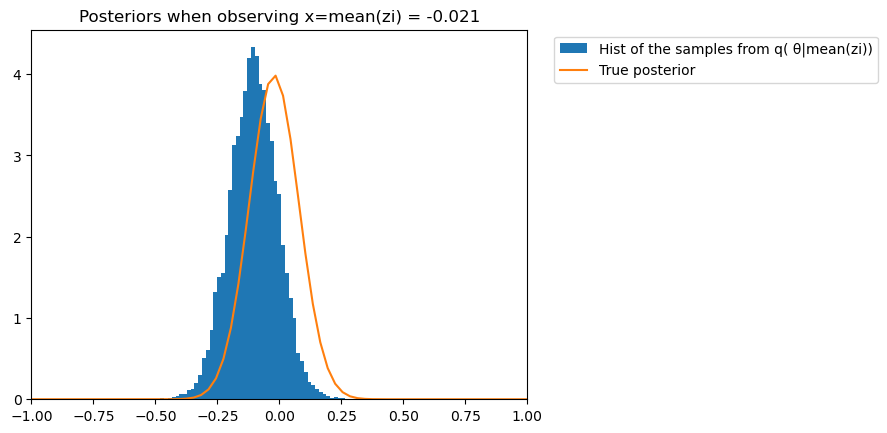

In [456]:
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(zi))")
x_star.squeeze_()
true_post_summaries = [posterior_x_N(theta, x_star.numpy()) for theta in theta_grid]
plt.plot(theta_grid, true_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi) = {x_star.item():.3f}")
plt.show()

## When taking the observed mean and variance as summaries : $$x = (x_1, x_2),\\ x_1=\frac{1}{N}\sum_{i=1}^{N}{zi} \\ x_2 = \frac{1}{N}\sum_{i=1}^N{\left( z_i-x_1 \right) }^2$$

In [457]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
x =data["mean_and_var"]["x"]
x_test = data_test["mean_and_var"]["x"]
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [458]:
x_star.squeeze()

tensor(-0.0213)

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

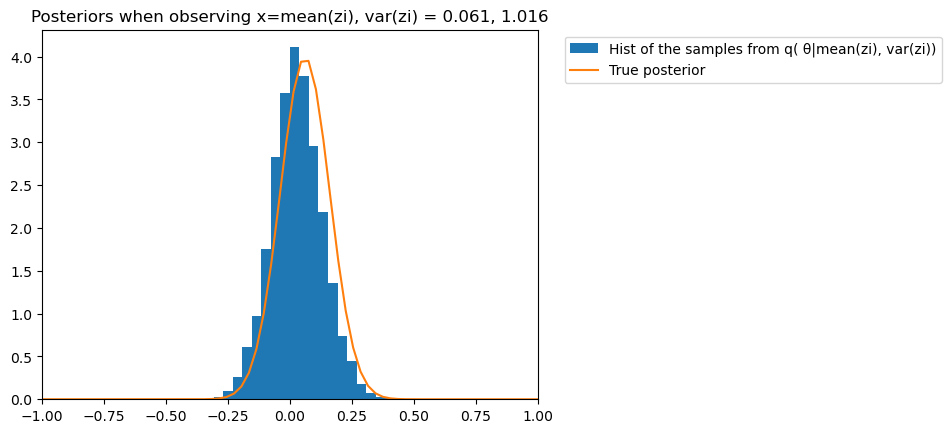

In [459]:
x_star = generate_data(theta_true, 1)["mean_and_var"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))
x_star.squeeze_()
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(zi), var(zi))")
eval_post_summaries = [posterior_summaries(theta, x_star[0].item(), x_star[1].item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi), var(zi) = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()

## Observing the mean $ x = \frac{1}{2} \left( z_1 + z_2 \right)$

In [460]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)

x = data["mean_two_z"]["x"]
x_test = data_test["mean_two_z"]["x"]
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)
x_star = generate_data(theta_true,1)["mean_two_z"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))
x_star.squeeze_()

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

tensor(0.3514)

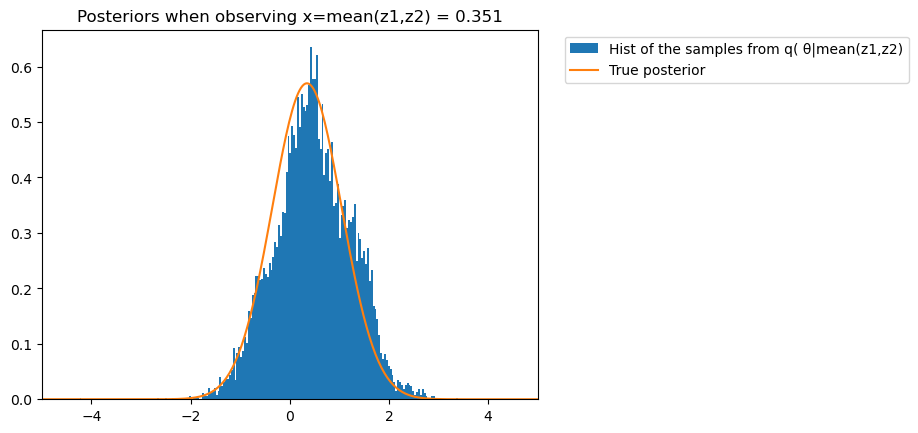

In [461]:
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(z1,z2)")
eval_post_summaries = [posterior_x(theta, x_star.item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(z1,z2) = {x_star.item():.3f}")
plt.show()

## Observing two realisations $ z_1,z_2$

In [462]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
x = data["two_z"]["x"]
x_test = data_test["two_z"]["x"]
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [463]:
x_star = generate_data(theta_true,1)["two_z"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))
x_star.squeeze_()

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

tensor([ 0.8035, -1.2490])

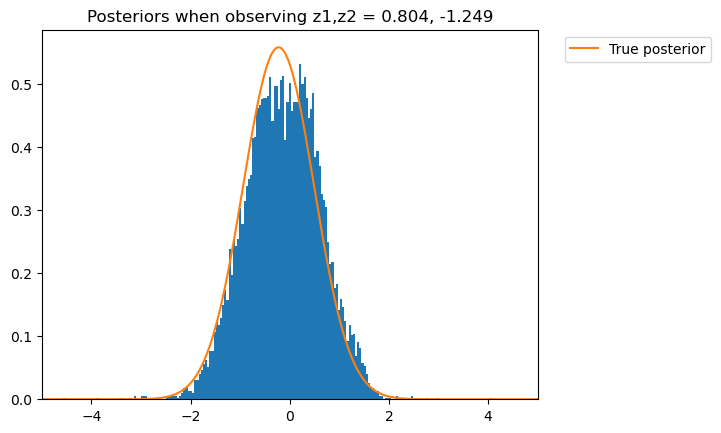

In [464]:
plt.hist(samples.squeeze_().numpy(),density=True, bins=200)
eval_post_summaries = [posterior_z(theta, x_star[0].item(), x_star[1].item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing z1,z2 = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()

In [465]:
#TODO Mettre avec obs=var

In [470]:
def get_posterior(summaries,theta,theta_test,theta_star,data,data_test,sigma_y_2):
    shape_x = lambda x: 2 if x=="mean_and_var" or x=="two_z" else 1
    flow = lampe.inference.NPE(theta_dim= 1, x_dim=shape_x(summaries) , build=build_nsf)
    loss = lampe.inference.NPELoss(flow)
    x =  data[summaries]["x"] 
    x_test = data_test[summaries]["x"]

    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    
    #Getting new observed data
    data_star = generate_data(theta_star,sigma_y_2)
    x_star = data_star[summaries]["x"]
    y_star = data_star[summaries]["eps"] + x_star
    flow.eval()
    #Getting samples from the trained flow
    with torch.no_grad():
        samples = flow.sample(x_star, (10_000,))
    x_star.squeeze_()
    #Getting the true posterior
    true_post_density, true_post_dist = get_true_post(summaries, x_star)
    
    y_star = data_star[summaries]["eps"] + x_star
    with torch.no_grad():
        samples_y = flow.sample(y_star, (10_000, ))
    
    return true_post_density, samples, samples_y, true_post_dist
    


In [484]:
def prepare_ax_posteriors(sigma_2):
    plt.close()
    sigma_y_2 = (sigma_2-1)
    summaries = ["two_z", "mean_two_z", "mean", "mean_and_var","var"]
    fig, ax = plt.subplots(3, 2, figsize=(10,10))
    i=0
    theta = prior.sample((M,))
    theta_test= prior.sample((M//10,))
    data = generate_data(theta,sigma_y_2)
    data_test = generate_data(theta_test,sigma_y_2)
    true_posts = {}
    samples_x = {}
    samples_y = {}
    true_dists = {}
    with tqdm(summaries, unit='summary statistic', leave=False,desc="Summaries") as tq:
        for summary in tq:
            tq.set_postfix(summary=summary)
            true_post, samples, sample_y, true_post_dist = get_posterior(summary,theta,theta_test, theta_true,data,data_test, sigma_y_2=sigma_y_2)
            row = i // 2  
            col = i % 2 
            
            hist1 = ax[row, col].hist(samples.squeeze_().numpy(), density=True, bins=200, label="SBI Posterior q(θ|x)", alpha=0.55)
            ax[row, col].plot(theta_grid, true_post, label="True posterior p(θ|x)")
            hist2 = ax[row, col].hist(sample_y.squeeze_().numpy(), density=True, bins=200, label="SBI Posterior q(θ|y)", alpha=0.5)
            ax[row, col].axvline(x=theta_true, ls='--', c='k')
        # ax[row, col].set_xlim(-1, 1)
            #if "mean_two_realisations" in summary:
            #   ax[row, col].set_xlim(-3,3)
            ax[row, col].set_title(f"using {summary} as summary")  
            lower_bound = min(min(samples), min(sample_y)) -2
            upper_bound = max(max(samples), max(sample_y)) +2
            ax[row, col].set_xlim(lower_bound, upper_bound)
            #ax[row, col].set_xlim(-3,3)
            ax[row, col].legend()
            i += 1
            samples_x[summary] = samples
            samples_y[summary] = samples_y
            true_posts[summary] = true_post
            true_dists[summary] = true_post_dist
    fig.suptitle(f"Posteriors with sigma² = {sigma_2}")
    return fig, true_posts, samples_x, samples_y, true_dists


In [485]:
results = {}
sigmas_2 = [1,2,3,4]
with tqdm(sigmas_2, unit='Sigma', desc="Sigmas") as tq:
    for sigma_2 in tq:
        results[sigma_2] = {}
        tq.set_postfix({"sigma²":sigma_2})
        results[sigma_2]["figure"], results[sigma_2]["true_post"], results[sigma_2]["samples"], results[sigma_2]["samples_y"], results[sigma_2]["true_dist"]  = prepare_ax_posteriors(sigma_2)
        plt.close()

Sigmas:   0%|          | 0/4 [00:00<?, ?Sigma/s]

Generating data:   0%|          | 0/1000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/100 [00:00<?, ?theta/s]

Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\matplotlib\cbook\__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/1000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/100 [00:00<?, ?theta/s]

Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/1000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/100 [00:00<?, ?theta/s]

Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/1000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/100 [00:00<?, ?theta/s]

Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

In [490]:
@widgets.interact(sigma_2=(1,4,1))
def plot_posteriors_widget(sigma_2=1):
    plt.close()
    return results[sigma_2]["figure"]

interactive(children=(IntSlider(value=1, description='sigma_2', max=4, min=1), Output()), _dom_classes=('widge…

In [491]:
def mcmc(density,n_sampes):
    
    def metropolis_sampler(p, nsamples, ):
        x = 1 # start somewhere
        proposal = lambda x: np.random.normal(x)
        for i in tqdm(range(nsamples)):
            trial = proposal(x) # random neighbour from the proposal distribution
            acceptance = p(trial)/p(x)
            # accept the move conditionally
            if np.random.uniform() < acceptance:
                x = trial
            yield x
    samples = list(metropolis_sampler(density, n_samples))
    return samples

In [492]:
def compute_distances(true_density, flow_samples):
    samples_true_distribution = mcmc(true_density,10_000)
    mu_true_distribution = np.mean(samples_true_distribution)
    std_true_distribution = np.std(samples_true_distribution)
    
    flow_mean = torch.mean(flow_samples).item()
    flow_std = torch.std(flow_samples).item()
    
    distance = np.square(mu_true_distribution - flow_mean) + np.square(np.log(std_true_distribution/flow_std))
    return distance

In [ ]:
todo : 
    graph selons les sigma? (ps changer xlim, prendre genre le min? ou un percentil?)
    voir en scalant les data si on perd

SyntaxError: invalid syntax (1814866518.py, line 1)